# Compare the calculated radial matrix elements to pairinteraction and ARC

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from numerov.matrix_elements import radial_matrix_element
from numerov.rydberg import RydbergState
from numerov.units import ureg

logging.basicConfig(level=logging.INFO, format="%(levelname)s %(filename)s: %(message)s")
logging.getLogger("numerov").setLevel(logging.WARNING)

In [2]:
# A few exemplary test cases, where pairinteraction and ARC do fail in various ways
dn, dl, dj, dm = (3, 1, 0, 0)
# dn, dl, dj, dm = (1, 0, 0, 0)
# dn, dl, dj, dm = (2, 0, 0, 0)
# dn, dl, dj, dm = (2, 2, 2, 0)
# dn, dl, dj, dm = (5, 1, 0, 0)
# dn, dl, dj, dm = (5, 2, 1, 0)
# qn_list: (n, l, j, mj)

qn1_list = np.array([(n1, n1 - 1, n1 - 0.5, n1 - 0.5) for n1 in range(20, 150)])
qn2_list = np.array([(n + dn, l + dl, j + dj, m + dm) for n, l, j, m in qn1_list])

In [3]:
matrixelements = {}

In [4]:
matrixelements["Numerov"] = []
for qn1, qn2 in zip(qn1_list, qn2_list):
    print(f"n={qn1[0]}", end="\r")
    state_i = RydbergState("Rb", qn1[0], qn1[1], qn1[2])
    state_f = RydbergState("Rb", qn2[0], qn2[1], qn2[2])
    state_i.integrate()
    state_f.integrate()
    matrixelements["Numerov"].append(radial_matrix_element(state_i, state_f, 1))

matrixelements["Numerov"] = np.array(matrixelements["Numerov"], dtype=float)
matrixelements["Numerov"] *= ureg.Quantity(1, "bohr_radius").to("micrometer").magnitude

In [5]:
matrixelements["Numerov Hydrogen"] = []
for qn1, qn2 in zip(qn1_list, qn2_list):
    print(f"n={qn1[0]}", end="\r")
    state_i = RydbergState("H", qn1[0], qn1[1], qn1[2])
    state_i.create_model(add_spin_orbit=False)
    state_f = RydbergState("H", qn2[0], qn2[1], qn2[2])
    state_f.create_model(add_spin_orbit=False)
    state_i.integrate()
    state_f.integrate()
    matrixelements["Numerov Hydrogen"].append(radial_matrix_element(state_i, state_f, 1))

matrixelements["Numerov Hydrogen"] = np.array(matrixelements["Numerov Hydrogen"], dtype=float)
matrixelements["Numerov Hydrogen"] *= ureg.Quantity(1, "bohr_radius").to("micrometer").magnitude

In [6]:
if int(np.__version__.split(".")[0]) < 2:
    import os

    from pairinteraction import pireal as pi

    os.makedirs("./.pairinteraction_cache/", exist_ok=True)
    cache = pi.MatrixElementCache("./.pairinteraction_cache/")

    # Pairinteraction Numerov
    cache.setMethod(pi.NUMEROV)
    matrixelements["pairinteraction numerov"] = []
    for qn1, qn2 in zip(qn1_list, qn2_list):
        print(f"n={qn1[0]}", end="\r")
        state_i = pi.StateOne("Rb", int(qn1[0]), int(qn1[1]), qn1[2], qn1[3])
        state_f = pi.StateOne("Rb", int(qn2[0]), int(qn2[1]), qn2[2], qn2[3])
        matrixelements["pairinteraction numerov"].append(cache.getRadial(state_f, state_i, 1))

    matrixelements["pairinteraction numerov"] = np.array(matrixelements["pairinteraction numerov"], dtype=float)

    # Pairinteraction Whittaker
    cache.setMethod(pi.WHITTAKER)
    matrixelements["pairinteraction whittaker"] = []
    for qn1, qn2 in zip(qn1_list, qn2_list):
        print(f"n={qn1[0]}", end="\r")
        state_i = pi.StateOne("Rb", int(qn1[0]), int(qn1[1]), qn1[2], qn1[3])
        state_f = pi.StateOne("Rb", int(qn2[0]), int(qn2[1]), qn2[2], qn2[3])
        matrixelements["pairinteraction whittaker"].append(cache.getRadial(state_f, state_i, 1))

    matrixelements["pairinteraction whittaker"] = np.array(matrixelements["pairinteraction whittaker"], dtype=float)
else:
    print(f"pairinteraction not available with numpy >= 2.0, but numpy {np.__version__} is installed.")

In [7]:
from arc_functions import arc_getRadialMatrixElement

import arc

atom = arc.Rubidium87()

for use_fixed_arc in [False, True]:
    key = "ARC fixed" if use_fixed_arc else "ARC default"
    matrixelements[key] = []
    for qn1, qn2 in zip(qn1_list, qn2_list):
        print(f"n={qn1[0]}", end="\r")
        v = arc_getRadialMatrixElement(
            atom, int(qn1[0]), int(qn1[1]), qn1[2], int(qn2[0]), int(qn2[1]), qn2[2], use_fixed_arc=use_fixed_arc
        )
        matrixelements[key].append(v)

    matrixelements[key] = np.array(matrixelements[key], dtype=float)
    matrixelements[key] *= ureg.Quantity(1, "bohr_radius").to("micrometer").magnitude

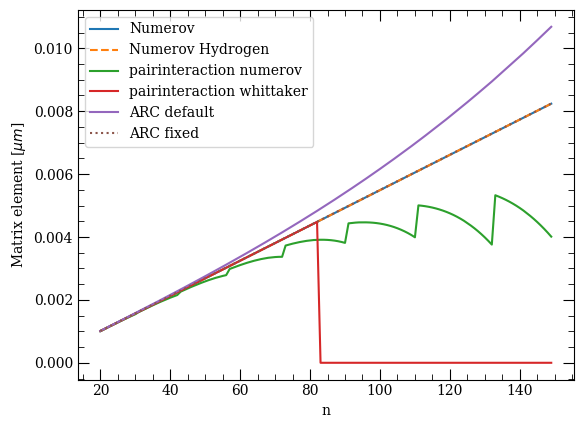

In [8]:
n_list = qn1_list[:, 0]
ls_dict = {"Numerov Hydrogen": "--", "ARC fixed": ":"}

fig, ax = plt.subplots()

for key, values in matrixelements.items():
    ls = ls_dict.get(key, "-")
    ax.plot(n_list, values, ls=ls, label=key)

ax.set_xlabel("n")
ax.set_ylabel(r"Matrix element [$\mu m$]")

ax.legend()
plt.show()